    Реализация модели с двумя различными входами.
    1 вход: эмбеддинги + билстм. Эмбеддинги получены с помощью BPE.
    2 вход: сворачивание one-hot исходных последовательностей.
    
    В качестве входных данных использовались последовательности длинной от 5 до 30 символов и предсказывался следующий символ, те бралась только информация слева.

`(train 0.5954, val 0.5368, test 0.54)`
`(эпох 160, батч 200)`

### Libraries

In [ ]:
!pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install 

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
    100% |████████████████████████████████| 20.9MB 454kB/s eta 0:00:01
    100% |████████████████████████████████| 5.5MB 1.7MB/s eta 0:00:01
    100% |████████████████████████████████| 522kB 8.4MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 12.8MB/s ta 0:00:01
    100% |████████████████████████████████| 870kB 6.5MB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 12.5MB/s ta 0:00:01
    100% |████████████████████████████████| 481kB 8.5MB/s eta 0:00:01
    100% |████████████████████████████████| 9.6MB 1.0MB/s eta 0:00:01
    100% |████████████████████████████████| 460kB 8.5MB/s eta 0:00:01
    100% |████████████████████████████████| 768kB 7.2MB/s eta 0:00:01
    100% |████████████████████████████████| 1.1MB 4.1MB/s ta 0:00:011
    100% |████████

    100% |████████████████████████████████| 901kB 6.4MB/s eta 0:00:01
    100% |████████████████████████████████| 153kB 11.5MB/s ta 0:00:01
    100% |████████████████████████████████| 174kB 11.3MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 13.5MB/s ta 0:00:01
    100% |████████████████████████████████| 245kB 9.6MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 14.4MB/s ta 0:00:01
    100% |████████████████████████████████| 112kB 12.9MB/s ta 0:00:01


  Stored in directory: /home/golubenko/.cache/pip/wheels/6d/e1/ce/f4ee2fa420cc6b940123c64992b81047816d0a9fad6b879325
  Stored in directory: /home/golubenko/.cache/pip/wheels/0d/71/2a/164491997299b9f2479a251e254323fe35d946779e18f27956
  Stored in directory: /home/golubenko/.cache/pip/wheels/15/df/fe/2a74fe34709e7fdc5ae153a768675d9fda93cc7d5133ed1fb0
  Stored in directory: /home/golubenko/.cache/pip/wheels/f1/ca/e5/bdd5eae705cf50a483257e6ff9dd34911dda3570f0e1340dda
  Stored in directory: /home/golubenko/.cache/pip/wheels/39/01/56/f1b08a6275acc59e846fa4c1e1b65dbc1919f20157d9e66c20
  Stored in directory: /home/golubenko/.cache/pip/wheels/a9/28/53/f24776b4c5bcbe91aaf1f1e247bd6fadd17191aa12fac63902

In [1]:
%reload_ext autoreload
%autoreload 2

In [5]:
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input, Reshape
from keras.layers import LSTM, Bidirectional, Conv1D, MaxPool1D, Embedding, Concatenate, Permute, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
curruser = os.environ.get('USER')

from keras.backend.tensorflow_backend import set_session
from keras import backend as K
import tensorflow as tf

import pandas as pd
import numpy as np
import bpe
from collections import Counter
from textwrap import wrap

import sys
sys.path.append('./src')
from PreprocInput import preproc_

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from pylab import rcParams
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

Using TensorFlow backend.


### Set GPU

In [6]:
with K.tf.device('/GPU:0'):
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    session = tf.Session(config=config)
    K.set_session(session)

### Secondary functions

In [2]:
def plot_metrics(history):
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [3]:
def confusion_matrix_heatmap(y_true, y_pred):
    '''
    Построение Confusion matrix (матрицы ошибок)

    Parameters
    ----------
    y_test: pandas.Series, numpy.array
        Целевая для обучающего набора
    y_pred: pandas.Series, numpy.array
        Значения целевой переменной, предсказанные классификатором
    '''
    rcParams['figure.figsize'] = 6, 4
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Load dataset and preproc

In [24]:
data = pd.read_csv('./data/LeftWrap_5to30.csv', sep=';')
data.head(5)

,seq,label
0,ACGGCTGGAGCCCATGTTCAGCATGAAAAC,A
1,TAAATTTCTGGATGGCAATGAAATGACATT,A
2,TCCACTTGGCAGCCAAATATGGCCAGACAA,A
3,CGGAGGAGAGCACCGAGCCCCTGAGTGAGG,A
4,GGACCACATTTGGGGAGCTTGCCATTTTAT,A


## Prepare 1-st Input: Tensor with Tokens' Id to be passed on Embed Layer

In [4]:
encoder = bpe.Encoder.load('./models/bpe_tokenizer_v2.h5')

In [14]:
encoder.bpe_vocab, encoder.bpe_vocab_size, encoder.word_vocab, encoder.vocab_size

({'__eow': 250,
  '__sow': 251,
  'g': 252,
  'a': 253,
  'c': 254,
  't': 255,
  'ag': 256,
  'ca': 257,
  'tg': 258,
  'cc': 259,
  'ga': 260,
  'gg': 261,
  'aa': 262,
  'ct': 263,
  'gc': 264,
  'tc': 265,
  'ac': 266,
  'at': 267,
  'tt': 268,
  'gt': 269,
  'ta': 270,
  'cg': 271,
  'cag': 272,
  'ctg': 273,
  'aga': 274,
  'tgg': 275,
  'cca': 276,
  'gga': 277,
  'gaa': 278,
  'gag': 279,
  'aag': 280,
  'cct': 281,
  'aaa': 282,
  'gcc': 283,
  'agc': 284,
  'ccc': 285,
  'agg': 286,
  'tga': 287,
  'ggc': 288,
  'gct': 289,
  'gca': 290,
  'tgc': 291,
  'caa': 292,
  'atg': 293,
  'aca': 294,
  'tca': 295,
  'gtg': 296,
  'tcc': 297,
  'ctc': 298,
  'acc': 299,
  'ggg': 300,
  'cac': 301,
  'tct': 302,
  'ttc': 303,
  'ctt': 304,
  'cat': 305,
  'gac': 306,
  'tgt': 307,
  'gat': 308,
  'aac': 309,
  'ttt': 310,
  'agt': 311,
  'ttg': 312,
  'atc': 313,
  'act': 314,
  'aat': 315,
  'att': 316,
  'ggt': 317,
  'gtc': 318,
  'ccg': 319,
  'cgg': 320,
  'gtt': 321,
  'tac': 322

In [25]:
def tokens_to_ids(encoder, x):
    x_toks = []
    for i in range(len(x)):
        encoder.tokenize(x[i])
        x_toks.append(next(encoder.transform([x[i]])))
    
    max_len = max(map(len, x_toks))
    X_arr = np.zeros((len(x_toks), max_len), dtype='int32')
    for i, s in enumerate(x_toks):
        X_arr[i, 0:len(s)] = s
    
    return X_arr

In [26]:
X_toks = tokens_to_ids(encoder, data.seq.values)

max(map(max,X_toks)), min(map(min,X_toks))

(499, 0)

## Prepare 2-nd Input: Create one-hot encoded vectors using the char_indices map

In [27]:
MAXCHARSLEN = max(map(len, data.seq.values))
MAXSEQLEN = max(map(len, X_toks))
MAXCHARSLEN, MAXSEQLEN

(30, 12)

In [28]:
chars = sorted(list(set(data.label.values)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [29]:
X_ids, y_ids = preproc_.get_input_array(data.seq.values, data.label.values, MAXCHARSLEN, chars, char_indices)

In [30]:
X_toks.shape, y_ids.shape, X_ids.shape

((3351352, 12), (3351352, 4), (3351352, 30, 4))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_toks, y_ids, random_state=42, 
                                                    shuffle=True, test_size=0.2)
X_train_cat, X_test_cat, _, _ = train_test_split(X_ids, y_ids, random_state=42, 
                                                 shuffle=True, test_size=0.2)

# Build and train model: Emb+Bilstm+batchnorm

In [15]:
def get_model(vocab_size, n_classes, seq_len_emb, seq_len_chars):
    
    inp = Input(shape =(seq_len_emb,), name='Input1')
    emb = Embedding(vocab_size, 256, name='BPE_emb')(inp)
    x = Bidirectional(LSTM(units=128, dropout=0.1, recurrent_dropout=0.1, 
                           return_sequences=True), name='BiLSTM')(emb)
    
    inp_ = Reshape(target_shape=(seq_len_emb,1), name='Expand_Dims')(inp)
    xlstm = Concatenate(name='Concat_LSTM')([x,inp_])
    x = Bidirectional(LSTM(units=128, dropout=0.1, recurrent_dropout=0.1, 
                           return_sequences=False), name='BiLSTM_1')(xlstm) 
    ###
    inp2 = Input(shape = (seq_len_chars, n_classes), name='Input2')
    y = Conv1D(kernel_size=3,
                filters=128,
                padding='valid',
                activation="relu",
                name='Conv1d-1')(inp2)
    y = MaxPool1D(pool_size=2, strides=2, name='MaxPool1d-1')(y)
    y = BatchNormalization(name='BatchNorm-1')(y)

    y = Conv1D(kernel_size=3,
                filters=128,
                padding='valid',
                activation="tanh",
                name='Conv1d-2')(y)
    y = MaxPool1D(pool_size=2, strides=2, name='MaxPool1d-2')(y)
    y = BatchNormalization(name='BatchNorm-2')(y)

    y = Conv1D(kernel_size=3,
                filters=128,
                padding='valid',
                activation="tanh",
                name='Conv1d_3')(y)
    y = MaxPool1D(pool_size=2, strides=2, name='MaxPool1d-3')(y)
    y = BatchNormalization(name='BatchNorm-3')(y)

    y = Dropout(0.2, name='Dropout_0.2')(y)
    y = Flatten(name='Flatten')(y)
    ###
    comb = Concatenate(name='Concat')([x,y])

    z = Dense(128, activation='tanh', name='Dense_128')(comb)
    z = Dense(n_classes, activation='softmax', name='Dense_NCLASS')(z)
    model = Model(inputs=[inp, inp2], outputs=z)
    plot_model(model = model, to_file = './same_/BiLSTM+emb-CNN.png', show_layer_names=False, show_shapes=True)
    model.summary()
    
    return model

In [16]:
VOCAB_SIZE = encoder.vocab_size

model = get_model(vocab_size = VOCAB_SIZE, n_classes=len(chars), 
                  seq_len_emb=MAXSEQLEN, seq_len_chars=MAXCHARSLEN)

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input2 (InputLayer)             (None, 30, 4)        0                                            
__________________________________________________________________________________________________
Conv1d-1 (Conv1D)               (None, 28, 128)      1664        Input2[0][0]                     
__________________________________________________________________________________________________
MaxPool1d-1 (MaxPooling1D)      (None, 14, 128)      0           Conv1d-1[0][0]                   
__________________________________________________________________________________________________
BatchNorm-1 (BatchNor

In [ ]:
# path = './same_/bilstm_emb_cnn_v2.h5'

callbacks = [EarlyStopping(patience=10, monitor='val_loss'),
             ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)]

BATCH_SIZE=200
n_epoch=160

history = model.fit([X_train, X_train_cat], y_train, batch_size=BATCH_SIZE, epochs=n_epoch, shuffle=True,
                     validation_split=0.2, verbose=1, callbacks=callbacks).history

In [19]:
plot_metrics(history)

NameError: name 'history' is not defined

# OOB validation

In [20]:
model = load_model(path)

y_pred = model.predict([X_test, X_test_cat])
y_pred = y_pred.argmax(axis=-1)

y_true = y_test.argmax(axis=-1)

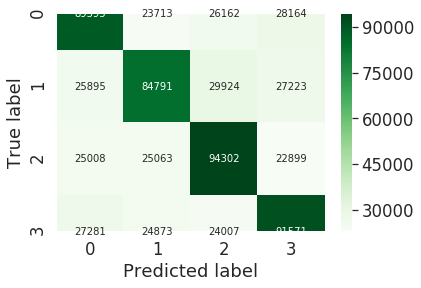

In [22]:
confusion_matrix_heatmap(y_true, y_pred)

In [23]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53    167434
           1       0.54      0.51      0.52    167833
           2       0.54      0.56      0.55    167272
           3       0.54      0.55      0.54    167732

    accuracy                           0.54    670271
   macro avg       0.54      0.54      0.54    670271
weighted avg       0.54      0.54      0.54    670271



# Train on new dataset

In [8]:
df = pd.read_csv('./data/SourceSeq.csv', sep=';')
df.head()

,seq
0,ATGGAGATCCCTGTGCCTGTGCAGCCGTCTTGGCTGCGCCGCGCCT...
1,ATGCAGAGGTCGCCTCTGGAAAAGGCCAGCGTTGTCTCCAAACTTT...
2,ATGCTTCTGGGCGAGCTGGGTGTGTTCGCCTCCTACGCCTTCGCGC...
3,ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...
4,ATGCTCTTTGAGGGCTTGGATCTGGTGTCGGCGCTGGCCACCCTCG...


In [9]:
def get_wrap_chunks(seq_list, min_seq_len, max_seq_len):
        new_seq = []
        for seq in seq_list:
            if len(seq) <= max_seq_len+1  & len(seq) >= min_seq_len+1:
                new_seq.append(seq)
            elif len(seq) < min_seq_len+1:
                pass
            else:
                chunks = wrap(seq[4:], max_seq_len+1)
                for i in chunks:
                    if len(i) >= min_seq_len+1:
                        new_seq.append(i)
                    else:
                        pass

        return new_seq

In [10]:
seqs = get_wrap_chunks(df.seq.values, min_seq_len=5, max_seq_len=30)

In [11]:
X = []
y = []

for s in seqs:
    X.append(s[:-1])
    y.append(s[-1:])

In [12]:
len(seqs), max(map(len,X)), min(map(len,X))

(3884467, 30, 5)

In [13]:
min_sample = min(Counter(y).values())

data2 = pd.DataFrame({'seq':X,'label':y})
data2 = data2.groupby(by='label', group_keys=False).apply(lambda x: x.sample(n=min_sample, random_state=42, 
                                                                             axis=0)).reset_index(drop=True)
data2.head()

,seq,label
0,GGCTTATCCGCCAGTATGACCTTCGAGAGA,A
1,CTGGTGGCAGCAATGGGAGCAGCAGCGGAA,A
2,CTCAGAAGCACTCAGCTACCTCAAGCCCAG,A
3,GATTTTCCTGGAGAGGGGGATCTGATCCAG,A
4,TATACTAACCCACAACTTCTGGAGCAACTT,A


In [14]:
data2 = data2.sample(frac=1)

In [15]:
encoder = bpe.Encoder.load('./same_/bpe_tokenizer_v2.h5')
X_toks = tokens_to_ids(encoder, data2.seq.values)

In [16]:
MAXCHARSLEN = max(map(len, data2.seq.values))
MAXSEQLEN = max(map(len, X_toks))
MAXCHARSLEN, MAXSEQLEN

(30, 11)

In [17]:
chars = sorted(list(set(data2.label.values)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [18]:
X_ids, y_ids = preproc_.get_input_array(data2.seq.values, data2.label.values, MAXCHARSLEN, chars, char_indices)

In [19]:
X_toks.shape, y_ids.shape, X_ids.shape

((3355288, 11), (3355288, 4), (3355288, 30, 4))

In [20]:
zero = np.zeros((X_toks.shape[0]), dtype='int')
X_toks = np.column_stack((X_toks, zero))

X_toks.shape

(3355288, 12)

In [21]:
model = load_model('./same_/bilstm_emb_cnn_v2.h5')

path2 = './same_/bilstm_emb_cnn_v3.h5'

callbacks = [EarlyStopping(patience=10, monitor='val_loss'),
             ModelCheckpoint(path2, monitor='val_loss', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)]

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

BATCH_SIZE=200
n_epoch=100

history = model.fit([X_toks, X_ids], y_ids, batch_size=BATCH_SIZE, epochs=n_epoch, shuffle=True,
                     validation_split=0.2, verbose=1, callbacks=callbacks).history

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2684230 samples, validate on 671058 samples
Epoch 1/100
2684230/2684230 [==============================] - 1825s 680us/step - loss: 1.3339 - acc: 0.3619 - val_loss: 1.2905 - val_acc: 0.3858

Epoch 00001: val_loss improved from inf to 1.29046, saving model to ./same_/bilstm_emb_cnn_v3.h5
Epoch 2/100
2684230/2684230 [==============================] - 1922s 716us/step - loss: 1.2837 - acc: 0.3924 - val_loss: 1.2732 - val_acc: 0.4025

Epoch 00002: val_loss improved from 1.29046 to 1.27316, saving model to ./same_/bilstm_emb_cnn_v3.h5
Epoch 3/100
2684230/2684230 [==============================] - 1916s 714us/step - loss: 1.2667 - acc: 0.4076 - val_loss: 1.2599 - val_acc: 0.4138

Epoch 00003: val_loss improved from 1.27316 to 1.25994, saving model to .

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2684230/2684230 [==============================] - 1912s 712us/step - loss: 1.0813 - acc: 0.5393 - val_loss: 1.1261 - val_acc: 0.5201

Epoch 00039: val_loss improved from 1.12870 to 1.12608, saving model to ./same_/bilstm_emb_cnn_v3.h5
Epoch 40/100
2684230/2684230 [==============================] - 1920s 715us/step - loss: 1.0791 - acc: 0.5408 - val_loss: 1.1265 - val_acc: 0.5201

Epoch 00040: val_loss did not improve from 1.12608
Epoch 41/100
2684230/2684230 [==============================] - 1914s 713us/step - loss: 1.0776 - acc: 0.5418 - val_loss: 1.1232 - val_acc: 0.5227

Epoch 00041: val_loss improved from 1.12608 to 1.12320, saving model to ./same_/bilstm_emb_cnn_v3.h5
Epoch 42/100
2684230/2684230 [==============================] - 1917s 714us/step - loss: 1.0756 - acc: 0.5427 - val_loss: 1.1219 - val_acc: 0.5231

Epoch 00042: val_loss improved from 1.12320 to 1.12189, saving model to ./same_/bilstm_emb_cnn_v3.h5
Epoch 43/100
2684230/2684230 [==============================] - 191

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1725000/2684230 [==================>...........] - ETA: 9:16 - loss: 1.0364 - acc: 0.5654

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2684230/2684230 [==============================] - 1667s 621us/step - loss: 1.0386 - acc: 0.5642 - val_loss: 1.0991 - val_acc: 0.5406

Epoch 00069: val_loss did not improve from 1.09881
Epoch 70/100
 152200/2684230 [>.............................] - ETA: 24:31 - loss: 1.0327 - acc: 0.5678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2684230/2684230 [==============================] - 1677s 625us/step - loss: 1.0373 - acc: 0.5650 - val_loss: 1.0988 - val_acc: 0.5415

Epoch 00070: val_loss improved from 1.09881 to 1.09880, saving model to ./same_/bilstm_emb_cnn_v3.h5
Epoch 71/100
2684230/2684230 [==============================] - 1661s 619us/step - loss: 1.0369 - acc: 0.5655 - val_loss: 1.0978 - val_acc: 0.5415

Epoch 00071: val_loss improved from 1.09880 to 1.09782, saving model to ./same_/bilstm_emb_cnn_v3.h5
Epoch 72/100
2684230/2684230 [==============================] - 1662s 619us/step - loss: 1.0357 - acc: 0.5661 - val_loss: 1.0969 - val_acc: 0.5423

Epoch 00072: val_loss improved from 1.09782 to 1.09689, saving model to ./same_/bilstm_emb_cnn_v3.h5
Epoch 73/100
2684230/2684230 [==============================] - 1661s 619us/step - loss: 1.0344 - acc: 0.5667 - val_loss: 1.0964 - val_acc: 0.5425

Epoch 00073: val_loss improved from 1.09689 to 1.09641, saving model to ./same_/bilstm_emb_cnn_v3.h5
Epoch 74/100
2684

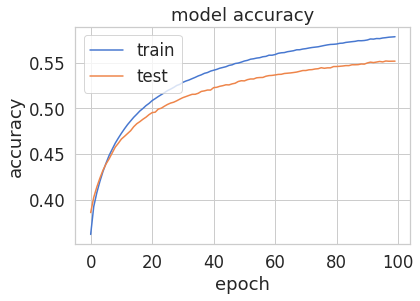

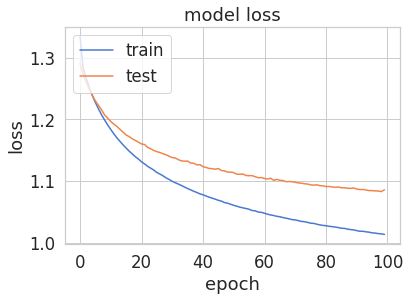

In [22]:
plot_metrics(history)

In [32]:
y_pred = model.predict([X_test, X_test_cat])
y_pred = y_pred.argmax(axis=-1)

y_true = y_test.argmax(axis=-1)

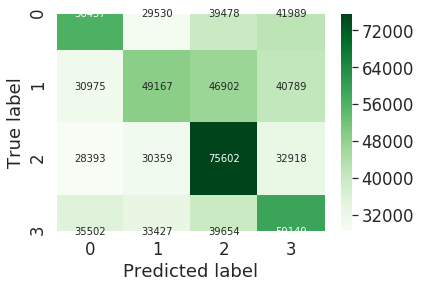

In [33]:
confusion_matrix_heatmap(y_true, y_pred)

In [34]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.34      0.35    167434
           1       0.35      0.29      0.32    167833
           2       0.37      0.45      0.41    167272
           3       0.34      0.35      0.35    167732

    accuracy                           0.36    670271
   macro avg       0.36      0.36      0.36    670271
weighted avg       0.36      0.36      0.36    670271

